# Linear Regression from Scratch: Exploring Gradient Descent

## Abstract
This notebook develops **linear regression**, with a focus on three core ideas:  
1. how a linear model is defined,  
2. how the **loss function** (Mean Squared Error) measures the quality of a fit  
3. how **gradient descent** optimizes the model parameters step by step.

All components are implemented **from scratch**
I generate several synthetic datasets with different characteristics (clean linear trend, varying noise levels, outliers, non-linear relationship, and no relation at all) and train the same linear model on each of them. This makes it possible to observe how the loss behaves, how the parameters $(m, b)$ evolve, and where linear regression works well or breaks down.

The core idea of this notebook is to understand deeper the **theory** and the **implementation** of linear regression, the MSE loss, and gradient descent, by explicitly connecting the mathematical formulas to concrete code and visual experiments.

---

## Overview

This notebook is a path from data generation to a simple working linear regression implementation from scratch.

- **Data generation and visualization**  
  I create several synthetic datasets with different behaviors (clean linear, noisy, with outliers, non-linear, random) and visualize them to build intuition on how they look.

- **Model and loss function**  
  I define the linear model $(\hat{y} = m x + b) $ and implement the Mean Squared Error (MSE) loss directly from its mathematical formula.

- **Gradient descent implementation**  
  I derive the gradients of the loss with respect to $(m)$ and $(b)$ and code a manual gradient descent loop that updates the parameters step by step.

- **Training on all datasets**  
  I run gradient descent on each dataset, store the training history, and inspect the learned parameters and loss values.

- **Analysis of results**  
  I visualize the fitted lines, the loss curves, and the evolution of $(m)$ and $(b)$ to see how noise, outliers, non-linearity, and randomness affect linear regression.



In [1]:
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset Creation

In [2]:
# random seed
np.random.seed(42)

# num of observation
n = 350

# indipendent
x = np.random.uniform(0.8, 15, n)  # uniform distribution over x

# original df
y_original = 10 * x + np.random.normal(0, 30, n)  # linear + noise
df = pd.DataFrame({'x': x, 'y': y_original})

# linear df less noise
y_low_noise = 10 * x + np.random.normal(0, 15, n)
df_linear = pd.DataFrame({'x': x, 'y': y_low_noise})

# noisy df
y_high_noise = 10 * x + np.random.normal(0, 70, n)
df_noise = pd.DataFrame({'x': x, 'y': y_high_noise})

# df with outliers
df_outliers = df.copy()
outliers_idx = np.random.choice(df_outliers.index, size = 40, replace = False)
# making 20 points outliers
df_outliers.loc[outliers_idx, 'y'] += 200

# non linear
y_nonlinear = 200 - 3 * (x - 10)**2 + np.random.normal(0, 30, n)
df_nonlinear = pd.DataFrame({'x': x, 'y': y_nonlinear})

# no relation
y_random = np.random.normal(100, 100, n)  # totally random
df_random = pd.DataFrame({'x': x, 'y': y_random})

# store all datasets in a dict
datasets = {
    'Original': df,
    'Low Noise': df_linear,
    'High Noise': df_noise,
    'Outliers': df_outliers,
    'non linear': df_nonlinear,
    'random': df_random,
}


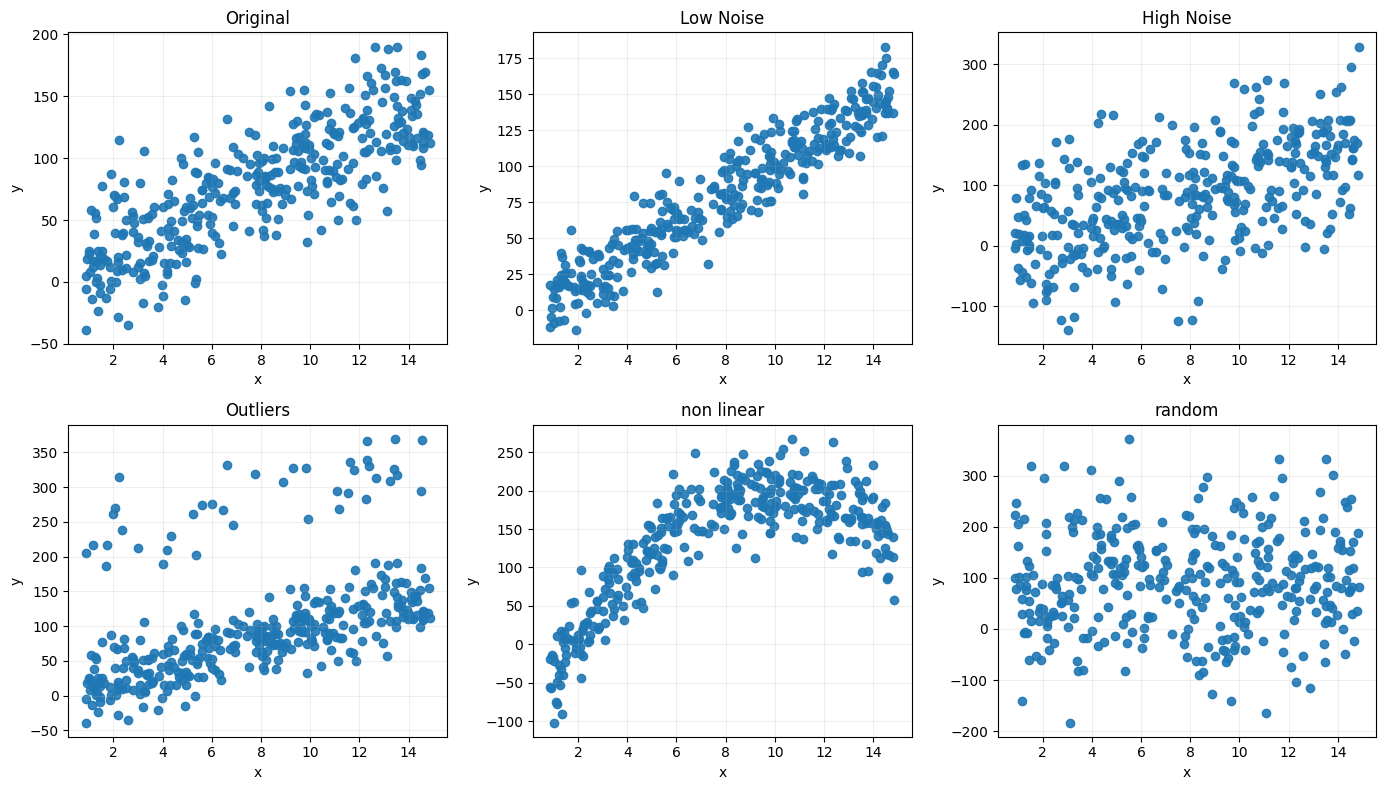

In [3]:
# plotting the datasets
n_cols = 3
n_rows = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(14,8))
ax = ax.ravel()

for axes, (name, data) in zip(ax, datasets.items()):
    axes.scatter(data.x, data.y, alpha=0.9)
    axes.set_title(name)
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

## Linear Regression Implementation
Simple linear model that i will use:

$$ \hat{y} = m x + b $$  

- $\hat{y}$ prediction of the model
- $x$ input
- $m$ slope,
- $b$ intercept / bias.

This is just a line, the interesting part come when we measure if the line is good and how we change the $m$ and $b$ to make it better.




## Loss Function - Mean Squared Error (MSE)
The loss function tell how good or how bad the model (ours line) is on the data.

In this notebook i use the mean squared error, it provide us a way to analize the accuracy of the model mesuring the avarage squared difference between the predicted values and the actual values on the datasets.
$$
E = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
- $E$: value of the loss
- $n$: number of data points
- $y_i$: true target value of the $_i$ point
- $\hat{y}_i$ prediction of the model for the $_i$ point

estesa:
$$
E = \frac{1}{n} \sum_{i=1}^{n} (y_i - (m x_i + b))^2 ~~~~~~~~~~~~~~~~~~~(1)
$$




In [4]:
# Loss Function from scratch
def loss_function(m, b, points):
  total_error = 0    # store the error
  for i in range(len(points)):
    x_i = points.iloc[i].x  # input
    y_i = points.iloc[i].y  # true value
    total_error += (y_i - (m * x_i + b))**2   #(1)

  # return MSE
  return total_error / float(len(points))

# This function is not directly used in the computation of linear regression
# becouse directly with gradient descent but useful for deeper understanding and
# for the future plot.

## Gradient Descent
**Gradient Descent** is an optimization teqnique to minimize the the cost function of a model. The idea is to iteratibly adjust the model parameters to reduce the difference between prdict and actual values, imporving the model performance.

In this case the cost function is the **Mean Squared Error** which measure how far the predictions are from the targets.
Gradient descent tries to find the values of the slope (m) and the bias (b) that minimize this MSE for give the best fit line.

The key idea is that the gradient tell us in wich direction the loss increses the most, to reduce that (ours goal) we want to move in the opposite direction.
$$
\begin{aligned}
m &:= m - L \, \frac{\partial E}{\partial m} ~~~~~~~~~~~~~~~~~~~(2)\\
b &:= b - L \, \frac{\partial E}{\partial b} ~~~~~~~~~~~~~~~~~~~(3)
\end{aligned}
$$
- $\frac{\partial E}{\partial m}$ and $\frac{\partial E}{\partial b}$ are the gradients (how much the loss changes if we change $m$ or $b$),  
- $L$ is the learning rate
- the **minus** sign means we move in the direction where the loss decreases, not increases.

For this we need to know how the loss change, and this is what the partial derivates $\frac{\partial E}{\partial m}$, $\frac{\partial E}{\partial b}$ tell.

$$
\begin{aligned}
\frac{\partial E}{\partial m} &= -\frac{2}{n} \sum_{i=1}^{n} x_i \, (y_i - (m x_i + b)) ~~~~~~~~~~~~~~~~~~~(4)\\
\frac{\partial E}{\partial b} &= -\frac{2}{n} \sum_{i=1}^{n} (y_i - (m x_i + b)) ~~~~~~~~~~~~~~~~~~~(5)
\end{aligned}
$$
- $E$: loss value (Mean Squared Error)  
- $\frac{\partial E}{\partial m}$: how much the loss $E$ changes when we change $m$  
- $\frac{\partial E}{\partial b}$: how much the loss $E$ changes when we change $b$  
- $\big(y_i - (m x_i + b)\big)$ error of the model on point $_i$ (MSE)
- $n$: number of data points in the dataset   
- the factor $\frac{2}{n}$: comes from the derivative of the squared error.




In [5]:
# gradient descent from scratch
def gradient_descent(m_now, b_now, points, L):
  m_gradient = 0
  b_gradient = 0

  # I use the notation m_now and b_now becouse helped me understand that we pass the current state
  # right now and from them compute the gradient and achive new m and b.

  n = len(points)
  # The formula of the partial derivate already include the MSE so i don't call the loss_function
  for i in range(n):
    x_i = points.iloc[i].x
    y_i = points.iloc[i].y

    # Gradient on the function, just implement the (4) and (5) equation.
    m_gradient += -(2/n) * x_i * (y_i - (m_now * x_i + b_now))  #(4)
    b_gradient += -(2/n) * (y_i - (m_now * x_i + b_now))      #(5)

  m = m_now - m_gradient * L   #(2)
  b = b_now - b_gradient * L   #(3)
  return(m,b)

'''
def gradient_descent(m_now, b_now, points, L):
  x = points["x"].values
  y = points["y"].values
  n = len(x)

  y_pred = m_now * x + b_now
  error = y - y_pred

  m_gradient = -(2/n) * np.sum(x * error)
  b_gradient = -(2/n) * np.sum(error)

  m = m_now - L * m_gradient
  b = b_now - L * b_gradient
  return m, b
'''

# This second version is more faster and is numpy style overall better but i find
# more meaningful for understand the theory behoynd the first one so i stay with that
# this second one is usable just uncomment and comment the first one


'\ndef gradient_descent(m_now, b_now, points, L):\n  x = points["x"].values\n  y = points["y"].values\n  n = len(x)\n\n  y_pred = m_now * x + b_now\n  error = y - y_pred\n\n  m_gradient = -(2/n) * np.sum(x * error)\n  b_gradient = -(2/n) * np.sum(error)\n\n  m = m_now - L * m_gradient\n  b = b_now - L * b_gradient\n  return m, b\n'

## Training on all datasets

This section is about train the linear regression model on each of the datasets using gradien descent.


In [6]:
# Training
L = 0.001   # learning rate
epochs = 500

# create dict for store info for the further plot
history = {}  # history for each df
models = {}   # final value for each df

# loop for train all the different datasets
for name, data in datasets.items():
  # initial paramether
  m = 0.0
  b = 0.0

  # data struct for save value
  m_history = []
  b_history = []
  loss_history = []

  # training loop
  for i in range(epochs):
    m, b = gradient_descent(m, b, data, L)
    m_history.append(m)
    b_history.append(b)
    loss_history.append(loss_function(m, b, data))

  # saving history in dict
  history[name] = {
      "m_history" : m_history,
      "b_history": b_history,
      "loss_history": loss_history,
  }
  # saving final value of m and b
  models[name] = (m, b)

  # print final value at the end of the train
  print(f"{name}: m = {m}, b = {b}, loss = {loss_function(m, b, data)}")

Original: m = 9.64595267226214, b = 2.0197066391929948, loss = 821.5949414322196
Low Noise: m = 10.135236287624416, b = 0.5611314853454515, loss = 214.16738718528367
High Noise: m = 10.74454822577907, b = 0.15383507235838592, loss = 4934.074025188658
Outliers: m = 11.588020111436087, b = 6.247585750553841, loss = 5055.066132845476
non linear: m = 15.614074382328047, b = 7.378697267224371, loss = 2950.211814816551
random: m = 7.709038943991824, b = 17.569647806755796, loss = 10303.030948492089


## Visualization

In this part i look at what train produce with different plot that show the linear regression line but also how the loss the slop and the bias evovld during the training


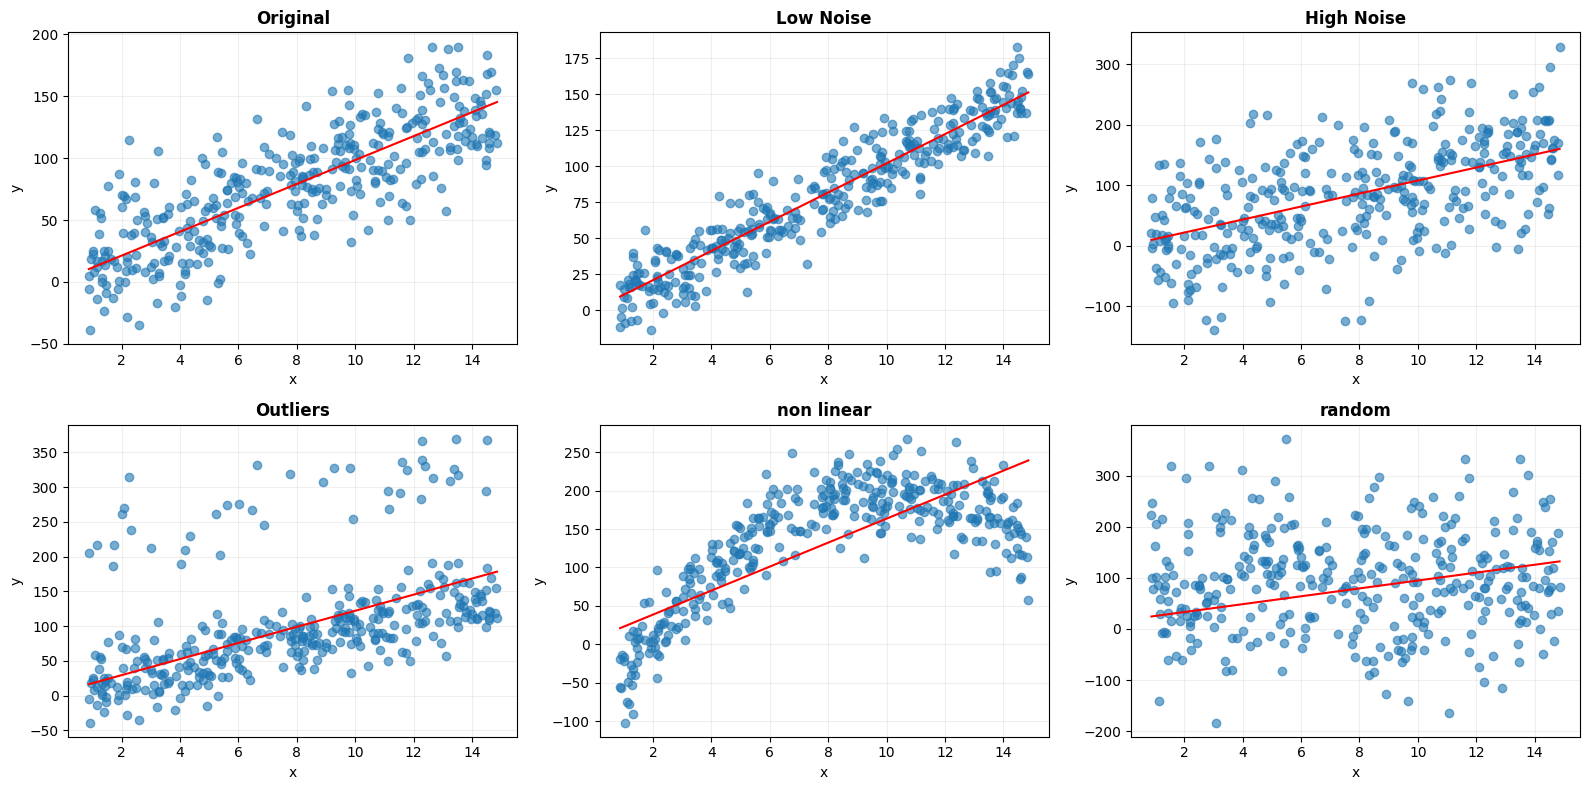

In [7]:
# Plottig linear regression
n_cols = 3
n_rows = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16,8))
ax = ax.ravel()


for axes, (name, data) in zip(ax, datasets.items()):
  axes.scatter(data.x, data.y, alpha=0.6)
  # regression line
  m, b = models[name]
  x_line = np.linspace(data.x.min(), data.x.max(), 100)
  y_line = m * x_line + b
  axes.plot(x_line, y_line, color="red")

  axes.set_title(name, fontweight="bold")
  axes.set_xlabel("x")
  axes.set_ylabel("y")
  axes.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

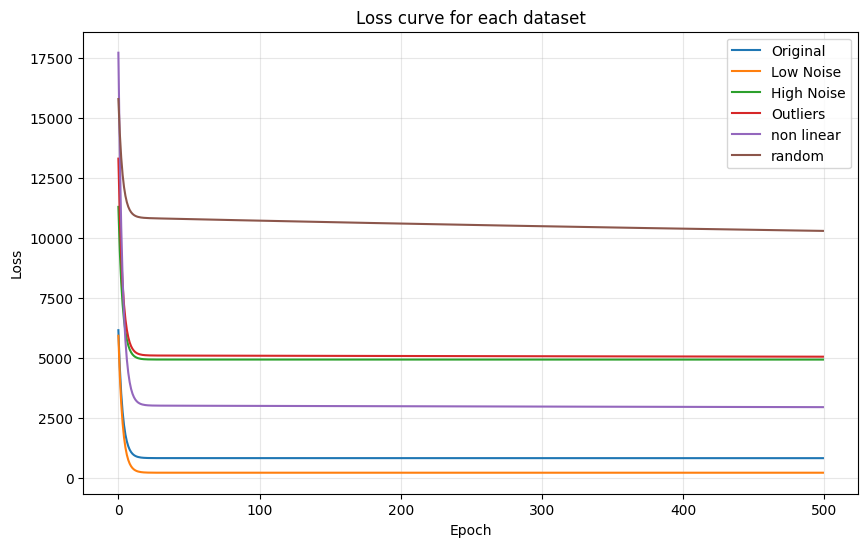

In [8]:
# Plotting loss function
plt.figure(figsize=(10, 6))

for name, h in history.items():
    plt.plot(h["loss_history"], label=name)

plt.title("Loss curve for each dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


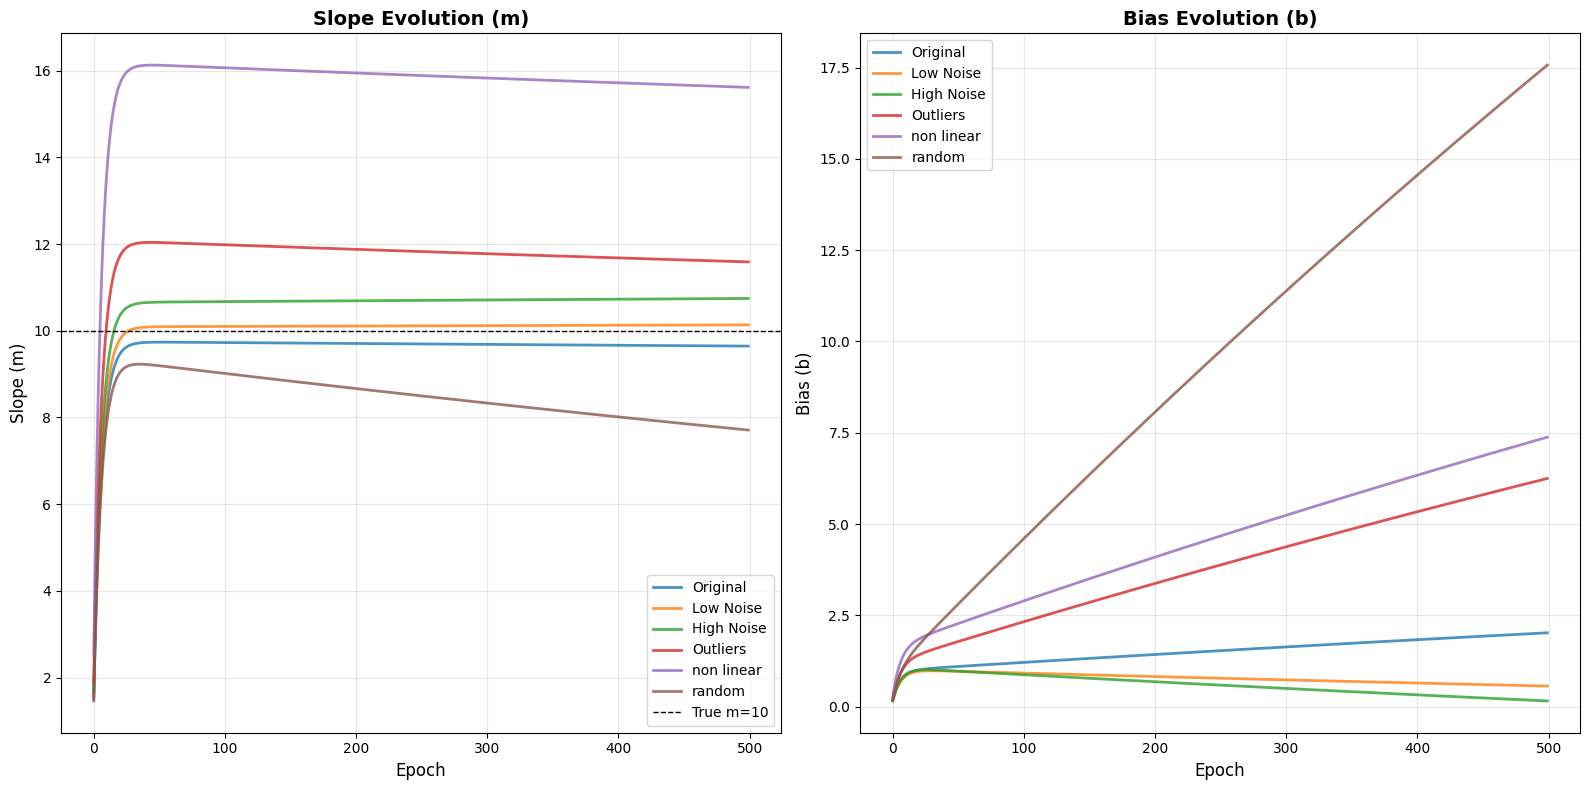

In [9]:
# After training and storing history
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: m evolution
for name, h in history.items():
    axes[0].plot(h["m_history"], label=name, alpha=0.8, linewidth=2)

# true slope m = 10
axes[0].axhline(y=10, color='black', linestyle='--', linewidth=1, label='True m=10')
axes[0].set_title("Slope Evolution (m)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Slope (m)", fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: b evolution
for name, h in history.items():
    axes[1].plot(h["b_history"], label=name, alpha=0.8, linewidth=2)

axes[1].set_title("Bias Evolution (b)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Bias (b)", fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusions

This notebook helped me to connect the theory to the implementation of this linear regression model, helping understanding better all the content.
I see also the difference between the dataset composition:
With the original and Low Noise dataset the model do exactly as expected, the learn line is very close to true linear trend, the loss go down near zero and the slope converge near 1. this is the ideal cases where the linear regression work really well and the MSE is a good measure of how well the line fit the data.

On high noise datasets the line still capture the trend but the points are much more spread out so the final loss is higher and the model can't get perfect predictions, not because the gradient descent but for the data itself is noisy.

The Outliers dataset show that this few extreme points can pull the line up and change the fit over the majority of the data. The MSE is sensitive to outliers so we need to handle this situation in others way maybe preprocessing the data.

The non linear dataset is difficult for the linear regression, the model still finds the best possible straight line for the data but cant follow the real shape. This show the limits of this model.

For the random dataset where there is not relation between x and y. The model give us a result but the line don't have a real meaning is just a line in the middle of the data.

This notebook in the end made the meaning of linear regression, MSE and gradient descent much more concrete, seeing the direct implementation on the of the equation.



---
## Future Work
An extension of this work could be move from one input x to multiple features and implement multiple linear regression, or another direction could be try different loss function testing Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) or Coefficient of Determination (R-squared)


